In [115]:
import numpy as np
import pandas as pd
import missingno as mn
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
import imblearn
print(imblearn.__version__)

0.7.0


# Importation des données

In [18]:
df =pd.read_csv("/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/dataproject.csv",encoding="utf-8",header=0, sep =";",decimal=',')

Il faut faire par chronologie, pas aleatoire, donc par mois , en fonction de la date 
train = 2 mois valide 
test = 1 mois 

In [19]:
df.head(10)

,ZIBZIN,IDAvisAutorisAtionCheque,MontAnt,DAteTrAnsAction,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,ScoringFP1,...,TAuxImpNB_CPM,EcArtNumCheq,NbrMAgAsin3J,DiffDAteTr1,DiffDAteTr2,DiffDAteTr3,CA3TRetMtt,CA3TR,Heure,FlAgImpAye
0,A034010041908012010710730,71051532,40.17,2016-03-21 07:47:38,0,1,1,1,535,0.000000,...,21.834061,0,1,4.0,4.0,4.0,40.17,0.0,28058,0
1,A035010041908006493331734,71051533,20.00,2016-03-21 08:04:57,0,0,0,0,358,0.000000,...,12.586532,0,1,4.0,4.0,4.0,20.00,0.0,29097,0
2,A013010003908005150136747,71051534,35.00,2016-03-21 08:06:45,0,0,0,0,199,0.000000,...,39.274924,0,1,4.0,4.0,4.0,35.00,0.0,29205,0
3,A013010041908025639221029,71051536,20.00,2016-03-21 08:11:38,0,0,0,0,38,0.000000,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29498,0
4,A013010003908005556100283,71051538,20.00,2016-03-21 08:17:11,0,0,0,0,26,0.000000,...,39.274924,0,1,4.0,4.0,4.0,20.00,0.0,29831,0
5,A007010278908891620264901,71051539,35.09,2016-03-21 08:17:26,0,0,0,0,459,0.000000,...,35.523979,0,1,4.0,4.0,4.0,35.09,0.0,29846,0
6,A056010003908116850002378,71051541,60.00,2016-03-21 08:19:56,0,0,0,0,500,0.000000,...,12.586532,0,1,4.0,4.0,4.0,60.00,0.0,29996,0
7,A034013506908085106167163,71051542,120.00,2016-03-21 08:20:42,0,1,1,1,389,0.308483,...,21.834061,0,1,4.0,4.0,4.0,120.00,0.0,30042,0
8,A056015589908090385895930,71051544,59.25,2016-03-21 08:21:04,0,1,1,1,538,0.000000,...,12.586532,0,1,4.0,4.0,4.0,59.25,0.0,30064,0
9,A056015589908093500453310,71051548,17.00,2016-03-21 08:22:56,0,0,0,0,13,0.000000,...,12.586532,0,1,4.0,4.0,4.0,17.00,0.0,30176,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ZIBZIN                    object 
 1   IDAvisAutorisAtionCheque  int64  
 2   MontAnt                   float64
 3   DAteTrAnsAction           object 
 4   CodeDecision              int64  
 5   VerifiAnceCPT1            int64  
 6   VerifiAnceCPT2            int64  
 7   VerifiAnceCPT3            int64  
 8   D2CB                      int64  
 9   ScoringFP1                float64
 10  ScoringFP2                float64
 11  ScoringFP3                float64
 12  TAuxImpNb_RB              float64
 13  TAuxImpNB_CPM             float64
 14  EcArtNumCheq              int64  
 15  NbrMAgAsin3J              int64  
 16  DiffDAteTr1               float64
 17  DiffDAteTr2               float64
 18  DiffDAteTr3               float64
 19  CA3TRetMtt                float64
 20  CA3TR                   

In [6]:
print(df.dtypes)

ZIBZIN                      object
IDAvisAutorisAtionCheque     int64
MontAnt                     object
DAteTrAnsAction             object
CodeDecision                 int64
VerifiAnceCPT1               int64
VerifiAnceCPT2               int64
VerifiAnceCPT3               int64
D2CB                         int64
ScoringFP1                  object
ScoringFP2                  object
ScoringFP3                  object
TAuxImpNb_RB                object
TAuxImpNB_CPM               object
EcArtNumCheq                 int64
NbrMAgAsin3J                 int64
DiffDAteTr1                 object
DiffDAteTr2                 object
DiffDAteTr3                 object
CA3TRetMtt                  object
CA3TR                       object
Heure                        int64
FlAgImpAye                   int64
dtype: object


In [7]:
df.describe()

,IDAvisAutorisAtionCheque,CodeDecision,VerifiAnceCPT1,VerifiAnceCPT2,VerifiAnceCPT3,D2CB,EcArtNumCheq,NbrMAgAsin3J,Heure,FlAgImpAye
count,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06,2.231369e+06
mean,7.356762e+07,1.288043e-02,3.991402e-01,4.296752e-01,4.816980e-01,2.477938e+02,6.724334e+03,1.034200e+00,5.347306e+04,2.804108e-03
std,1.458268e+06,1.682062e-01,5.250070e-01,6.056457e-01,7.339127e-01,2.131088e+02,1.742520e+05,1.862585e-01,1.200173e+04,5.287955e-02
min,7.105153e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.336000e+03,0.000000e+00
25%,7.232987e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.248500e+04,0.000000e+00
50%,7.353719e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.430000e+02,0.000000e+00,1.000000e+00,5.488200e+04,0.000000e+00
75%,7.480167e+07,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.680000e+02,0.000000e+00,1.000000e+00,6.390700e+04,0.000000e+00
max,7.619241e+07,3.000000e+00,1.500000e+01,4.000000e+01,4.000000e+01,5.510000e+02,9.993474e+06,1.000000e+01,8.256400e+04,1.000000e+00


# Null values

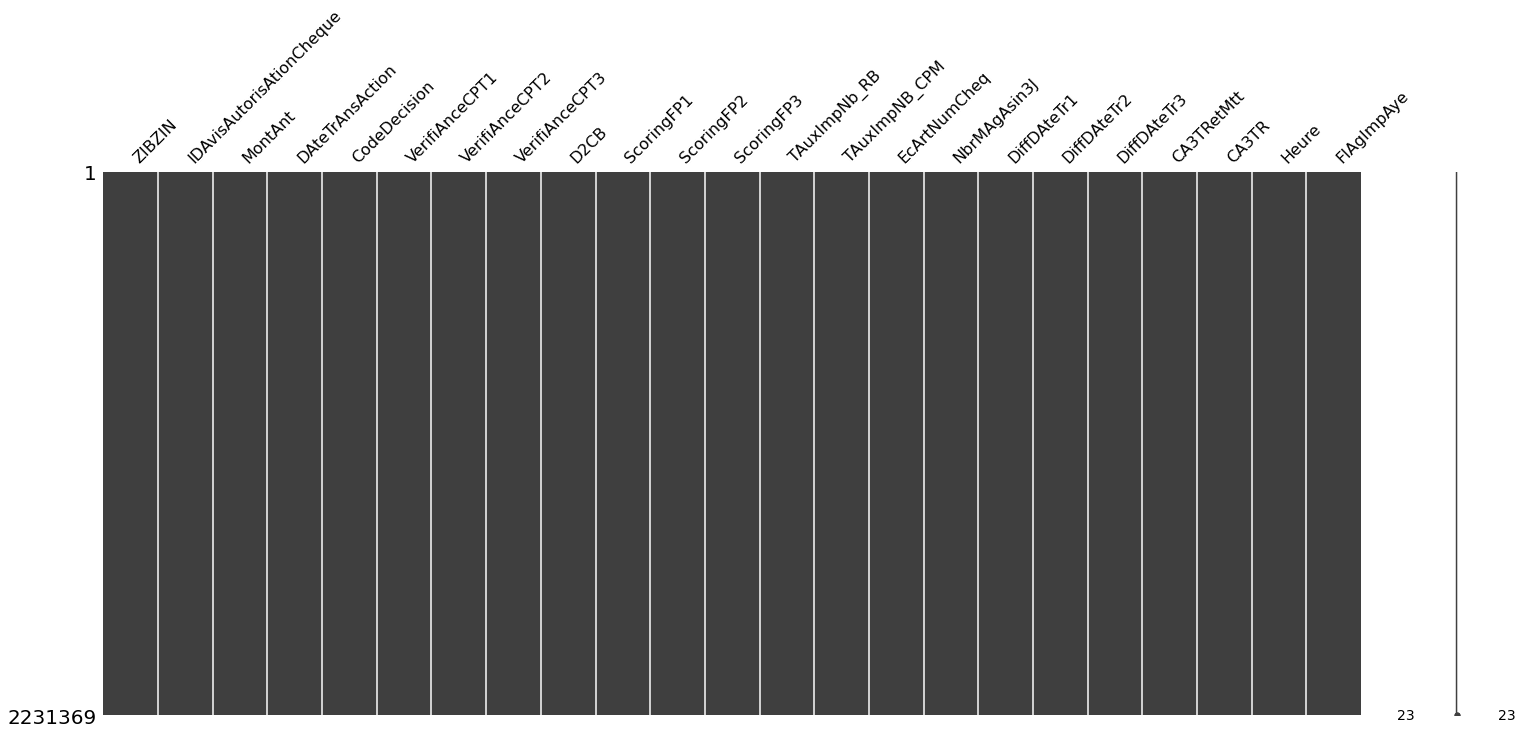

In [10]:
# Null Values
mn.matrix(df)

In [12]:
null_df_perc = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
null_df_perc.columns = ['Column Name', 'Null Values Percentage']
null_df_value = pd.DataFrame(df.isnull().sum()).reset_index()
null_df_value.columns = ['Column Name', 'Null Values']
null_df = pd.merge(null_df_value, null_df_perc, on='Column Name')
null_df.sort_values(by='Null Values Percentage', ascending=False)

,Column Name,Null Values,Null Values Percentage
0,ZIBZIN,0,0.0
12,TAuxImpNb_RB,0,0.0
21,Heure,0,0.0
20,CA3TR,0,0.0
19,CA3TRetMtt,0,0.0
18,DiffDAteTr3,0,0.0
17,DiffDAteTr2,0,0.0
16,DiffDAteTr1,0,0.0
15,NbrMAgAsin3J,0,0.0
14,EcArtNumCheq,0,0.0


In [14]:
print(df.isnull().sum())

ZIBZIN                      0
IDAvisAutorisAtionCheque    0
MontAnt                     0
DAteTrAnsAction             0
CodeDecision                0
VerifiAnceCPT1              0
VerifiAnceCPT2              0
VerifiAnceCPT3              0
D2CB                        0
ScoringFP1                  0
ScoringFP2                  0
ScoringFP3                  0
TAuxImpNb_RB                0
TAuxImpNB_CPM               0
EcArtNumCheq                0
NbrMAgAsin3J                0
DiffDAteTr1                 0
DiffDAteTr2                 0
DiffDAteTr3                 0
CA3TRetMtt                  0
CA3TR                       0
Heure                       0
FlAgImpAye                  0
dtype: int64


Il y a 0 null values 

# Analyse univarié

In [6]:
pd.value_counts(df['FlAgImpAye'])

0    2225112
1       6257
Name: FlAgImpAye, dtype: int64

On peut voir que la classe "frauduleuse" est extremement petite par rapport que la classe normale. En fait, dans ce cas la, oversampling sera mieux comme on ne veut pas perdre les infos importants sur les classes

## Extraire Mois pour Train et Test

Le but est de creer train et test chrono, pas en aléatoire donc nous allons observer la repartition de mois

In [83]:
df['DAteTrAnsAction'] = pd.to_datetime(df['DAteTrAnsAction'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231369 entries, 0 to 2231368
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ZIBZIN                    object        
 1   IDAvisAutorisAtionCheque  int64         
 2   MontAnt                   float64       
 3   DAteTrAnsAction           datetime64[ns]
 4   CodeDecision              int64         
 5   VerifiAnceCPT1            int64         
 6   VerifiAnceCPT2            int64         
 7   VerifiAnceCPT3            int64         
 8   D2CB                      int64         
 9   ScoringFP1                float64       
 10  ScoringFP2                float64       
 11  ScoringFP3                float64       
 12  TAuxImpNb_RB              float64       
 13  TAuxImpNB_CPM             float64       
 14  EcArtNumCheq              int64         
 15  NbrMAgAsin3J              int64         
 16  DiffDAteTr1               float64       
 17  DiffDAte

In [75]:
df['Month']=df['DAteTrAnsAction'].dt.month
a=pd.value_counts(df['Month'])
print(df['Month'].unique())

[ 3  4  5  6  7  8  9 10]


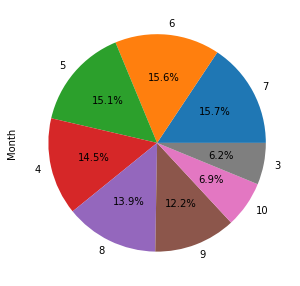

In [76]:
plot = a.plot.pie(y='Month', figsize=(5, 5),autopct='%1.1f%%')

Donc nous avons 8 mois en total,le premier et le dernier et celui qui a le moins activité.

# Train et Test

In [131]:
Apprenti = df.loc[df['DAteTrAnsAction'] < '2016-09-20'] 
Test = df.loc[df['DAteTrAnsAction'] >= '2016-09-20'] 
print(Apprenti['DAteTrAnsAction'].unique())
print(Test['DAteTrAnsAction'].unique())

['2016-03-21T07:47:38.000000000' '2016-03-21T08:04:57.000000000'
 '2016-03-21T08:06:45.000000000' ... '2016-09-19T21:15:19.000000000'
 '2016-09-19T21:43:41.000000000' '2016-09-19T21:51:09.000000000']
['2016-09-20T07:33:50.000000000' '2016-09-20T08:05:18.000000000'
 '2016-09-20T08:06:20.000000000' ... '2016-10-19T21:29:04.000000000'
 '2016-10-19T21:46:26.000000000' '2016-10-19T21:57:52.000000000']


On va créer les variables en supprimant les valeurs ID + Date + Heure qui ne nous concernce pas vraiment

In [147]:
training_features= Apprenti.drop(Apprenti.columns[[0, 1,3,21,22,23]], axis=1) 
training_target = Apprenti['FlAgImpAye']
#print(X_train.shape)
print(training_features.info())
print(training_target)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967226 entries, 0 to 1967225
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   MontAnt         float64
 1   CodeDecision    int64  
 2   VerifiAnceCPT1  int64  
 3   VerifiAnceCPT2  int64  
 4   VerifiAnceCPT3  int64  
 5   D2CB            int64  
 6   ScoringFP1      float64
 7   ScoringFP2      float64
 8   ScoringFP3      float64
 9   TAuxImpNb_RB    float64
 10  TAuxImpNB_CPM   float64
 11  EcArtNumCheq    int64  
 12  NbrMAgAsin3J    int64  
 13  DiffDAteTr1     float64
 14  DiffDAteTr2     float64
 15  DiffDAteTr3     float64
 16  CA3TRetMtt      float64
 17  CA3TR           float64
dtypes: float64(11), int64(7)
memory usage: 285.2 MB
None
0          0
1          0
2          0
3          0
4          0
          ..
1967221    0
1967222    0
1967223    0
1967224    0
1967225    1
Name: FlAgImpAye, Length: 1967226, dtype: int64


Donc on va définir l'ensemble d'entrainement, de validation et test.

In [148]:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.3,
                                                  shuffle=False 
                                                  )

In [149]:
test_features= Test.drop(Apprenti.columns[[0, 1, 3,21,22,23]], axis=1) 
test_target = Test['FlAgImpAye']

Test ( en commentaire )

In [24]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

TypeError: '(slice(None, None, None), slice(None, 2, None))' is an invalid key

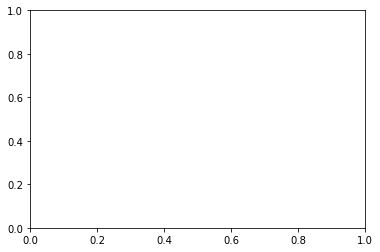

In [25]:
ax = plt.gca()
plot_decision_function(X[:, :2][:1000], y[:1000], LinearSVC().fit(X[:, :2][:5000], y[:5000]), ax)

# SMOTE OverSamplingwith Random Forest

In [26]:
#training_features, test_features, \
#training_target, test_target, = train_test_split(df.drop(df.columns[[0, 1, 3,21,22]], axis=1),
                                               #df['FlAgImpAye'],
                                               #test_size = .1,
                                               #random_state=12)

In [27]:
#x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  #test_size = .1,
                                                 # random_state=12)

In [150]:
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)


In [117]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=25, random_state=12))
#clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
#clf_rf.fit(x_train_res, y_train_res)
pipe.fit(x_train_res, y_train_res) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, random_state=12))])

In [37]:
print ('Validation Results')
print (clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (f1_score(y_val, clf_rf.predict(x_val)))
print ('\nTest Results')
print (clf_rf.score(test_features, test_target))
print (recall_score(test_target, clf_rf.predict(test_features)))
print (f1_score(test_target, clf_rf.predict(test_features)))

Validation Results
0.9935366290881568
0.1099290780141844
0.08720112517580873

Test Results
0.9933807481502396
0.10725552050473186
0.08431494110353377


# Exporter and save 

In [102]:
  %notebook '/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'

FileNotFoundError: [Errno 2] No such file or directory: "'/Users/hoangkhanhle/Desktop/School/Master 2/Big Data/ProjetFraud/BIG DATA.ipynb'"